In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as Fun
import math
from matplotlib import pyplot as plt

In [2]:
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Load traces

In [3]:
traces_file = '../traces/trace-omnetpp-5mb.csv'
nrows = 1419938 # number of traces to use (debug purposes)
# nrows = 64000 # number of traces to use (debug purposes)
batch_size = 256
sequence_length = 64
target_length = 10
print('number of traces: ', len(pd.read_csv(traces_file)))
print('number of traces used: ', nrows)

traces = pd.read_csv(traces_file, nrows=nrows)
print(traces[0:100])
# Split into train and test
dataset_length = 1419938
train_data = traces[:3*int(dataset_length/4)]
test_data = traces[3*int(dataset_length/4):]
print(test_data[0:100])
print(len(train_data))

number of traces:  1419938
number of traces used:  1419938
    pc  delta_in  delta_out
0    0         0        151
1    0       151          1
2    0         1         20
3    0        20       -171
4    0      -171        172
..  ..       ...        ...
95   0         1          1
96   0         1          1
97   0         1          1
98   0         1          1
99   0         1          1

[100 rows x 3 columns]
         pc  delta_in  delta_out
1064952   0         1        466
1064953   0       466          1
1064954   0         1        437
1064955   0       437         -9
1064956   0        -9          1
...      ..       ...        ...
1065047   0        11          1
1065048   0         1          1
1065049   0         1          1
1065050   0         1          1
1065051   0         1        784

[100 rows x 3 columns]
1064952


### Create vocabulary

In [4]:
# Cuda details should not be part of dataset.
label_encoder_pc = LabelEncoder()
label_encoder_deltas = LabelEncoder()
class PrefetchingDataset(Dataset):
    def __init__(self, pc, delta_in):
        #self.targets = targets
        self.delta_in = label_encoder_deltas.transform(delta_in)
        self.pcs = pc
       
    
    def __len__(self):
        return (int(batch_size * math.floor(len(self.delta_in)/batch_size)) - batch_size)

    def __getitem__(self, idx):
        #pcs = Fun.one_hot(torch.tensor(self.pcs[idx:idx+sequence_length]), max(num_pc, num_output_next))
        #deltas = Fun.one_hot(torch.tensor(self.delta_in[idx:idx+sequence_length]), max(num_pc, num_output_next))
        #pcs = torch.tensor(self.pcs[idx:idx+sequence_length])
        pcs = self.pcs[idx:idx+sequence_length]
        deltas = torch.tensor(self.delta_in[idx:idx+sequence_length])
        
        targets = Fun.one_hot(torch.tensor(self.delta_in[idx+sequence_length]), num_output_next)
    
        
        return (pcs, deltas, targets)

def load_data(data, batch_size):
    deltas = data['delta_in']
    data['pc_encoded'] = label_encoder_pc.transform(data['pc'].values)
    pc = torch.tensor(data['pc_encoded'].values)
    dataset = PrefetchingDataset(pc, deltas)
    print("Dataset:", len(dataset))
    # Create a DataLoader instance
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Get unique target keys
    target_keys = set(deltas.unique())
    print("Data loader", len(data_loader))
    return data_loader, len(label_encoder_pc.classes_), len(label_encoder_deltas.classes_), len(label_encoder_deltas.classes_), target_keys

label_encoder_pc.fit(list(set().union(train_data['pc'].values, test_data['pc'].values)))
label_encoder_deltas.fit(list(set().union(train_data['delta_in'].values, test_data['delta_in'].values)))
train_iter, num_pc, num_delta_in, num_output_next, target_keys = load_data(train_data, batch_size=batch_size)
test_iter, _, _, _, _ = load_data(test_data, batch_size=batch_size)
# add 1 for the next delta which is not in the training set
num_pc += 1
num_delta_in += 1
num_output_next += 1
print("Train iter:", len(train_iter))
print('number of unique pc: ', num_pc)
print('number of unique input delta: ', num_delta_in)
print('number of unique output delta: ', num_output_next)


Dataset: 1064448
Data loader 4158
Dataset: 354560
Data loader 1385
Train iter: 4158
number of unique pc:  2
number of unique input delta:  2562
number of unique output delta:  2562


/tmp/ipykernel_5216/1371905417.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pc_encoded'] = label_encoder_pc.transform(data['pc'].values)
/tmp/ipykernel_5216/1371905417.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pc_encoded'] = label_encoder_pc.transform(data['pc'].values)


1064952
5 highest bins: [491944. 154277.  33708.  33523.]
  their ranges: [(0.0, 100.0), (-100.0, 0.0), (100.0, 200.0), (-200.0, -100.0)]


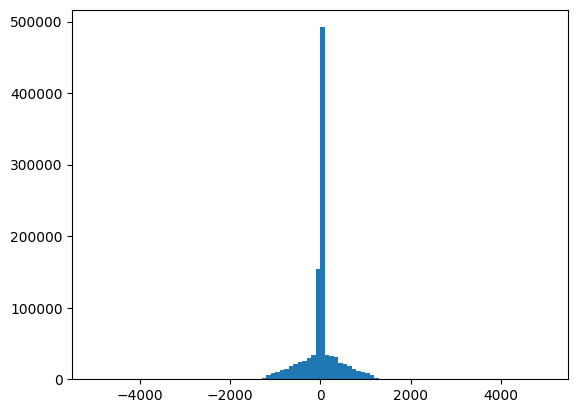

In [5]:
# Histogram of the data.
values, bins, patches = plt.hist(train_data['delta_in'], bins=100, range=[-5000, 5000])
order = np.argsort(values)[::-1]
print(len(train_data['delta_in']))
print("5 highest bins:", values[order][:4])
print("  their ranges:", [ (bins[i], bins[i+1])   for i in order[:4]])

plt.show()

In [6]:
_, cts = np.unique(train_data['delta_in'], axis=0, return_counts=True)
len(np.where(cts < 10)[0])

25

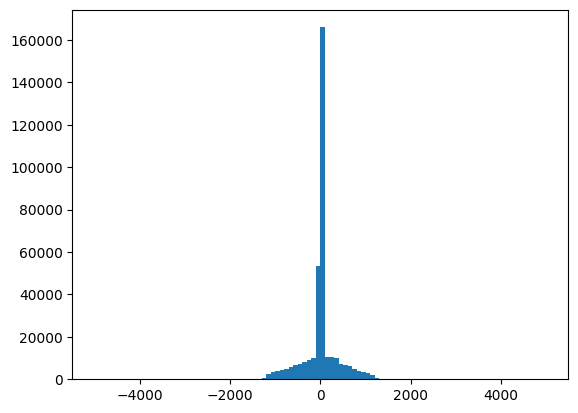

In [7]:
plt.hist(test_data['delta_in'], bins=100, range=[-5000,5000])
plt.show()

### Define LSTM model

In [8]:
class EmbeddingLSTM(nn.Module):
    def __init__(self, num_pc, num_delta_in, num_output_next, embed_dim, hidden_dim, output_dim, topPredNum, num_layers, dropout):
        # Layer structure is described in the paper
        super(EmbeddingLSTM, self).__init__()
        self.topPredNum = topPredNum
        # Define embedding layers
        # TODO(yisheng): Num_pc should be the input history size.
        self.pc_embed_layer = nn.Embedding(num_pc, embed_dim)
        # TODO(yisheng): Num_pc and num_delta will be the same
        self.delta_embed_layer = nn.Embedding(num_delta_in, embed_dim)
        # Define LSTM layer
        # LSTM input dimension: (pc_embed + delta_embed) * 2
        # What does concat mean? and dimension should be the same as embed_dim
        lstm_input_dim = embed_dim
        self.lstm = nn.LSTM(lstm_input_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        # Define output layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        # Define dropout layer
        # TODO: why is this needed?
        self.dropout = nn.Dropout(p=dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, h_c_state, target=None):
        pc, delta = x
        pc_embed = self.pc_embed_layer(pc)
        delta_embed = self.delta_embed_layer(delta)
        #pc_delta_embed_out = torch.cat([pc_embed, delta_embed], dim = -1).to(torch.float32)
        lstm_out, (h_0, c_0) = self.lstm(delta_embed, h_c_state)
        # lstm_out shape: (batch_size, seq_len, hidden_dim)
        #outputs = self.fc(lstm_out)
        state = (h_0, c_0)
        # out = h_0[-1]
        #out_dropout = self.dropout(h_0[-1])
        out = self.fc(h_0[-1])
        
        #out = self.sigmoid(out)
        if target is not None:
            loss = nn.CrossEntropyLoss()(out, target.to(torch.float32)) 
        else:
            loss = None
        
        # Get top k predictions
        _, preds = torch.topk(out, self.topPredNum, sorted=False)
        return preds, state, loss

    def predict(self, X, lstm_state):
        with torch.no_grad():
            preds, state, _ = self.forward(X, lstm_state)
            return preds, state



### Tune hyperparameters here

In [9]:
# Set up hyperparameters
hparams = {
    "topPredNum": 10,
    "embed_dim": 128,
    "hidden_dim": 128,
    "output_dim": num_output_next,
    "num_layers": 2,
    "dropout": 0.1,
    "learning_rate": 0.001,
    "epochs": 10
}

### Train the model

In [10]:
# Initialize the model with hyperparameters
my_model = EmbeddingLSTM(
    num_pc,
    num_delta_in,
    num_output_next,
    hparams["embed_dim"],
    hparams["hidden_dim"],
    hparams["output_dim"],
    topPredNum=hparams["topPredNum"],
    num_layers=hparams["num_layers"],
    dropout=hparams["dropout"]
)

# Prepare for training
train_loss = []
my_model = my_model.to(device)
optimizer = torch.optim.Adam(my_model.parameters(), lr=hparams["learning_rate"])

# Start training
for epoch in range(hparams["epochs"]):
    # Switch to training mode
    my_model.train()
    h_0 = torch.zeros(hparams["num_layers"], batch_size, hparams["hidden_dim"]).to(device)
    c_0 = torch.zeros(hparams["num_layers"], batch_size, hparams["hidden_dim"]).to(device)
    lstm_state = (h_0, c_0)
    for idx, batch in enumerate(train_iter):
        batch = [ds.to(device) for ds in batch]
        inputs = batch[:-1]
        targets = batch[-1]
        optimizer.zero_grad()
        _, lstm_state, batch_loss = my_model(inputs, lstm_state, targets)
        batch_loss.backward()
        optimizer.step()
        train_loss.append(float(batch_loss.item()))
        if idx%1000 == 0:
            print(f"Epoch {epoch + 1}, Iteration {idx}, Loss: {train_loss[-1]:.8f}")
        lstm_state = tuple([s.data for s in lstm_state])    

Epoch 1, Iteration 0, Loss: 7.92769432
Epoch 1, Iteration 1000, Loss: 5.09734583
Epoch 1, Iteration 2000, Loss: 5.08143139
Epoch 1, Iteration 3000, Loss: 5.15915108
Epoch 1, Iteration 4000, Loss: 5.29819727
Epoch 2, Iteration 0, Loss: 2.68749666
Epoch 2, Iteration 1000, Loss: 4.86569309
Epoch 2, Iteration 2000, Loss: 4.97386646
Epoch 2, Iteration 3000, Loss: 4.99211884
Epoch 2, Iteration 4000, Loss: 5.09304237
Epoch 3, Iteration 0, Loss: 2.78231764
Epoch 3, Iteration 1000, Loss: 4.66643953
Epoch 3, Iteration 2000, Loss: 4.81561661
Epoch 3, Iteration 3000, Loss: 4.78381634
Epoch 3, Iteration 4000, Loss: 4.95222425
Epoch 4, Iteration 0, Loss: 2.82680130
Epoch 4, Iteration 1000, Loss: 4.54473352
Epoch 4, Iteration 2000, Loss: 4.72323513
Epoch 4, Iteration 3000, Loss: 4.65907955
Epoch 4, Iteration 4000, Loss: 4.86699009
Epoch 5, Iteration 0, Loss: 2.75480962
Epoch 5, Iteration 1000, Loss: 4.48854828
Epoch 5, Iteration 2000, Loss: 4.67945433
Epoch 5, Iteration 3000, Loss: 4.65572357
Epoch 5

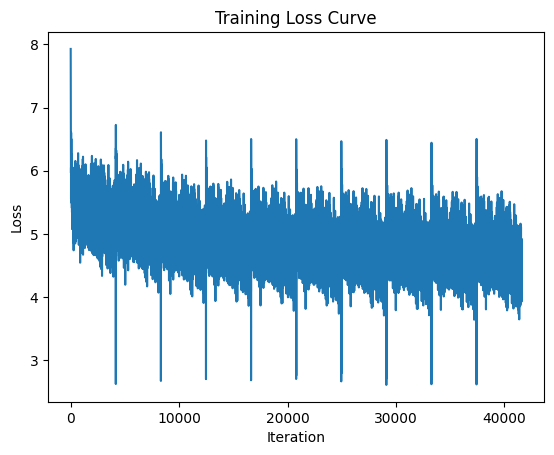

In [11]:
plt.plot(train_loss)
plt.title("Training Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

### Validate the model

In [12]:
def validate_model(network, data_iterator, relevant_keys, computing_device="cpu", initial_state=None):
    network.eval()

    accuracy_metrics = [process_batch(i, batch_data, network, computing_device, initial_state, relevant_keys) 
                        for i, batch_data in enumerate(data_iterator)]

    average_accuracy = torch.tensor(accuracy_metrics).mean()
    print("Average Validation Accuracy: {:.4f}".format(average_accuracy))

def process_batch(batch_index, batch_data, network, device, state, keys):
    print(f"Processing batch {batch_index}")

    batch_data = [item.to(device) for item in batch_data]
    input_data = batch_data[:-1]
    labels = batch_data[-1]
    labels = torch.argmax(labels, dim = 1)
    
    predictions, state = network.predict(input_data, state)
    accuracy = compute_accuracy(predictions, labels, keys)

    return accuracy

def compute_accuracy(predictions, labels, keys):
    combined_data = list(zip(labels, predictions))
    count_correct = sum([1 for label, predicted in combined_data 
                         if label.item() in keys and label in predicted])
    
    return count_correct / len(labels)

validate_model(my_model, train_iter, target_keys, computing_device=device)


Processing batch 0
Processing batch 1
Processing batch 2
Processing batch 3
Processing batch 4
Processing batch 5
Processing batch 6
Processing batch 7
Processing batch 8
Processing batch 9
Processing batch 10
Processing batch 11
Processing batch 12
Processing batch 13
Processing batch 14
Processing batch 15
Processing batch 16
Processing batch 17
Processing batch 18
Processing batch 19
Processing batch 20
Processing batch 21
Processing batch 22
Processing batch 23
Processing batch 24
Processing batch 25
Processing batch 26
Processing batch 27
Processing batch 28
Processing batch 29
Processing batch 30
Processing batch 31
Processing batch 32
Processing batch 33
Processing batch 34
Processing batch 35
Processing batch 36
Processing batch 37
Processing batch 38
Processing batch 39
Processing batch 40
Processing batch 41
Processing batch 42
Processing batch 43
Processing batch 44
Processing batch 45
Processing batch 46
Processing batch 47
Processing batch 48
Processing batch 49
Processing

In [13]:
validate_model(my_model, test_iter, target_keys, computing_device=device)


Processing batch 0
Processing batch 1
Processing batch 2
Processing batch 3
Processing batch 4
Processing batch 5
Processing batch 6
Processing batch 7
Processing batch 8
Processing batch 9
Processing batch 10
Processing batch 11
Processing batch 12
Processing batch 13
Processing batch 14
Processing batch 15
Processing batch 16
Processing batch 17
Processing batch 18
Processing batch 19
Processing batch 20
Processing batch 21
Processing batch 22
Processing batch 23
Processing batch 24
Processing batch 25
Processing batch 26
Processing batch 27
Processing batch 28
Processing batch 29
Processing batch 30
Processing batch 31
Processing batch 32
Processing batch 33
Processing batch 34
Processing batch 35
Processing batch 36
Processing batch 37
Processing batch 38
Processing batch 39
Processing batch 40
Processing batch 41
Processing batch 42
Processing batch 43
Processing batch 44
Processing batch 45
Processing batch 46
Processing batch 47
Processing batch 48
Processing batch 49
Processing